In [1627]:
from matplotlib import pyplot as plt

import miniflow.op as op    
import miniflow.executor as executor
import numpy as np
from miniflow.node import Node
import importlib
from typing import List

In [1628]:
importlib.reload(op)
importlib.reload(executor)

<module 'miniflow.executor' from 'E:\\ASC\\assignment02\\miniflow\\miniflow\\executor.py'>

In [1629]:
class MyLinear:
    def __init__(self, input_size, output_size, layer_id,input_node=None):
        self.input_size = input_size
        self.output_size = output_size
        # W: input * output
        
        if input_node is None:
            self.input_node = op.Variable("X")
        else:
            self.input_node = input_node
        self.W = op.Variable(f"W_{layer_id}")
        self.W_val = np.random.normal(0,1,size=(self.input_size, self.output_size))
        self.B = op.Variable(f"B_{layer_id}")
        self.B_val = 0.0
        
        self.rst = op.add_op(op.matmul_op(self.input_node, self.W), self.B)
        
        self.forward_executor = executor.Executor([self.rst])
        # -2 W -3 B
        # 标签节点
        #  上一次计算的值
        self.last_rst_val = 0.0
        
    
    def __call__(self, *args, **kwargs):
        return self.forward(*args, **kwargs)
    
    def forward(self, input):
        # input_size: batch * d
        feed_dict = {self.input_node: input, self.W: self.W_val, self.B: self.B_val}
        run_dict = self.forward_executor.run(feed_dict)
        self.last_rst_val = run_dict[-1]
        return run_dict[-1]

In [1630]:
class Relu(op.Op):
    def __call__(self, node):
        new_node = op.Op.__call__(self)
        new_node.name = f"relu_{node.name}"
        new_node.inputs = [node]
        return new_node

    def compute(self, node, input_vals):
        return np.maximum(input_vals[0], 0)

    def gradient(self, node, output_grad) -> List[Node]:
        # relu dx = dy dy > 0
        # dx = 0 dy <= 0
        return [relu_op(output_grad)]
    
relu_op = Relu()

relu_op.compute(None, [np.array([1,1,1,1,0,0,1,-1])])

array([1, 1, 1, 1, 0, 0, 1, 0])

In [1631]:
class MyMLP:
    def __init__(self, input_size, hidden_size, output_size, use_relu=True):
        self.L1 = MyLinear(input_size, hidden_size,1)
        if use_relu:
            self.rl_node = relu_op(self.L1.rst)
            self.L2 = MyLinear(hidden_size, output_size, 2, input_node=self.rl_node)
        else:
            self.L2 = MyLinear(hidden_size, output_size, 2, input_node=self.L1.rst)
        
        self.minus_node = op.add_const_op(self.L2.rst, 0)
        self.loss_node = None
        self.loss_executor = None
        # 反向传播的梯度节点
        self.grad_node_list = None
        # 初始化反向传播执行器，初始化计算图
        self.backward_executor = None
        
        self.need_grad_val_list = [self.L1.W_val, self.L1.B_val, self.L2.W_val, self.L2.B_val]
        self.backward_executor = executor.Executor([self.L1.W, self.L1.B, self.L2.W, self.L2.B])
        
        self.last_input = 0.0
        self.last_loss_val = 0.0
    
    def __call__(self, *args, **kwargs):
        return self.forward(*args, **kwargs)    
    
    def forward(self, input):
        self.last_input = input
        
        feed_dict = {self.L1.input_node: input, self.L1.W: self.L1.W_val, self.L1.B: self.L1.B_val,
                    self.L2.W: self.L2.W_val, self.L2.B: self.L2.B_val}
        
        l2_output_val = self.L2.forward_executor.run(feed_dict)[-1]
        return l2_output_val
    
    def compute_loss_and_backward(self, label, lr):
        self.minus_node.const_attr = -label
        if self.loss_node is None:
            self.loss_node = op.matmul_op(self.minus_node, self.minus_node, trans_A=True)
            self.loss_executor = executor.Executor([self.loss_node])
            # 反向传播的梯度节点
            self.grad_node_list = executor.gradient(self.loss_node,
                                                   [self.L1.W, self.L1.B, self.L2.W, self.L2.B])
            # 初始化反向传播执行器，初始化计算图
            self.backward_executor = executor.Executor(self.grad_node_list)
        
        
        feed_dict={self.L1.input_node: self.last_input, self.L1.W: self.L1.W_val, self.L1.B: self.L1.B_val,
                    self.L2.W: self.L2.W_val, self.L2.B: self.L2.B_val}
        self.last_loss_val = self.loss_executor.run(feed_dict)[-1]
        # print(f"loss: {self.last_loss_val}")
        grad_val_list = self.backward_executor.run(feed_dict)
        # print(grad_val_list[0])
        
        self.L1.W_val -= lr * grad_val_list[0]
        self.L1.B_val -= lr * grad_val_list[1]
        self.L2.W_val -= lr * grad_val_list[2]
        self.L2.B_val -= lr * grad_val_list[3]

        return self.last_loss_val
            

        
        

测试正向传播

In [1632]:
batch_size = 64
input_size = 3
hidden_size = 16
output_size = 1

mlp = MyMLP(input_size, hidden_size, output_size, use_relu=True)
X = np.random.rand(batch_size, input_size)
mlp.forward(X)

array([[2.06174023],
       [6.45474595],
       [2.38483431],
       [3.95660688],
       [3.69886686],
       [2.53196995],
       [3.97511126],
       [3.91321339],
       [7.00820222],
       [2.16439917],
       [6.31749296],
       [3.74047185],
       [6.61443415],
       [3.12177281],
       [7.03394442],
       [1.07941292],
       [2.30162424],
       [4.68995658],
       [2.25381861],
       [4.00624274],
       [4.51035631],
       [2.76402961],
       [2.82958423],
       [3.59457921],
       [6.75522916],
       [3.08116751],
       [3.29299658],
       [3.99660945],
       [3.76401092],
       [4.07766864],
       [1.48043819],
       [2.20756866],
       [3.29356384],
       [4.59362442],
       [6.21263718],
       [3.77468553],
       [2.79419249],
       [1.83150891],
       [6.7987857 ],
       [5.72173718],
       [5.29724445],
       [3.9795539 ],
       [3.50343033],
       [1.23393138],
       [6.14775966],
       [4.30638078],
       [3.05000012],
       [5.673

In [1633]:
np.random.seed(42)
w1 = np.random.normal(size=(input_size, hidden_size))
b1 = 0
w2 = np.random.normal(size=(hidden_size, output_size))
b2 = 0
np.random.seed(None)
def get_norm_output(X, noise = False):
    H = np.dot(X, w1) + b1
    if noise:
        H += np.random.normal(batch_size, hidden_size)
    Y = np.dot(H, w2) + b2
    if noise:
     Y += np.random.normal(batch_size, output_size)
    Y = Y.reshape(-1, 1)
    return Y

测试反向传播

[[2225.59711977]]
[[1903.94061435]]
[[1799.04068552]]
[[2607.54605954]]
[[1886.65906815]]
[[1069.91654823]]
[[1173.53548436]]
[[1027.50480073]]
[[1001.94353767]]
[[789.53182106]]
[[780.33519058]]
[[494.98903399]]
[[651.25895638]]
[[617.95840311]]
[[651.62064271]]
[[764.77689518]]
[[702.58490401]]
[[611.20913521]]
[[269.91881619]]
[[528.31248745]]
[[354.36810467]]
[[738.45829768]]
[[608.29470962]]
[[365.57199337]]
[[282.69040332]]
[[363.33161355]]
[[423.90773385]]
[[384.28887803]]
[[370.97545429]]
[[265.32797022]]
[[274.64898152]]
[[276.27358796]]
[[174.06801377]]
[[201.60009454]]
[[328.23915867]]
[[220.2753623]]
[[176.61364887]]
[[172.20001746]]
[[207.79807298]]
[[240.13064469]]
[[230.14551164]]
[[251.93831818]]
[[222.7930222]]
[[295.66907936]]
[[156.18560496]]
[[235.29089753]]
[[228.37770956]]
[[149.55993976]]
[[188.91453745]]
[[124.85881901]]
[[282.34517679]]
[[253.65276119]]
[[186.55269145]]
[[250.72249518]]
[[202.01492638]]
[[218.08483087]]
[[255.49776879]]
[[230.55897749]]
[[196.1

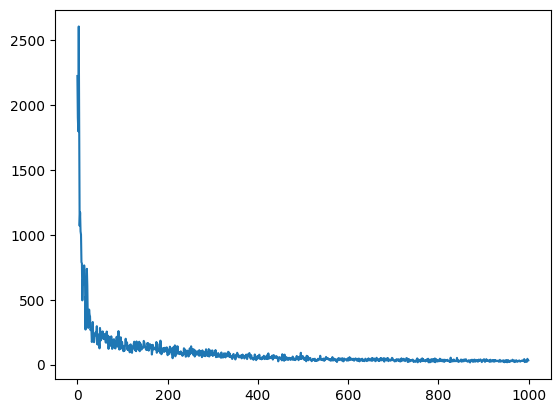

In [1634]:
loss_list = []
for i in range(1000):
    X = np.random.normal(size=(batch_size, input_size))
    mlp(X)
    Y = get_norm_output(X, noise = False)
    loss_val = mlp.compute_loss_and_backward(Y, 0.0001)
    print(loss_val)
    loss_list.append(loss_val.item())
    
plt.plot(loss_list)

[ -0.33840386  -1.32441338  -1.52639666  -2.86165184   2.74384428
   2.91553291   1.93299445   0.77678029  -5.4644999    5.9393614
  -1.00186155  -2.66374676  -7.13162913   3.51405901   5.51887062
  -2.96855852   1.76891428  -1.79727407   6.48835958  12.59726152
   8.93321949  -2.46953495  -7.62135737  -2.82625503   1.68778011
  -1.44934526  -0.196718    -8.70753423  -3.45675776  -7.29064896
  -1.84098582   8.56692004   0.84772734   3.54291217  -8.18293059
  -2.84784418  -0.09626501  -0.35674784  -3.88288514  -9.16297541
   7.76385347  -5.3398967    8.16471117  -4.47180393   0.20834283
  -3.90703866  -1.30338457  13.31316495  -1.84738482  -7.21671468
  -5.67403792  -3.64043356   9.36969197  -4.80780998   6.4441384
  -2.92959854  -8.45955178   1.9830617    2.33208823   1.43271314
   5.68188174   4.5825554    3.90707979 -14.71696821]
[  0.20235859  -0.66891938  -1.17486372  -2.60864292   2.68206396
   2.74539237   1.89098759   0.74631087  -5.38639927   6.3802923
  -1.38108694  -2.9174497

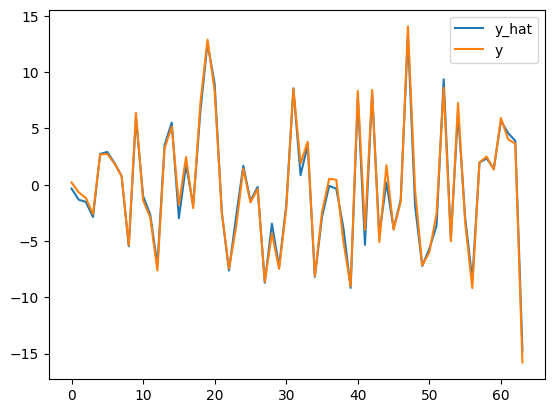

In [1635]:
X = np.random.normal(size=(batch_size, input_size))
Y_hat = mlp(X).reshape(-1)
print(Y_hat)
Y = get_norm_output(X, noise = False).reshape(-1)
print(Y)
plt.figure()
plt.plot(Y_hat, label='y_hat')
plt.plot(Y, label='y')
plt.legend()

In [1636]:

print(mlp.L1.W_val)
print(mlp.L1.B_val)
print(mlp.L2.W_val)
print(mlp.L2.B_val)

[[ 2.48059442  2.51044368  0.23742611 -2.0564093  -0.92884834  0.75434265
   0.83298537  1.80916245 -0.35474555 -1.01584774  2.62732084  0.59730529
  -1.38391907  0.83600281 -0.09522616  2.10041371]
 [-2.36607206 -1.40162216  0.15492964  0.53719691 -0.12848298  0.24380036
  -1.94968848  0.88923879  1.12003134 -1.48377378 -0.13721172  0.15582577
   1.04570607 -2.00612425  2.16148828 -1.48052457]
 [-0.07742218 -0.4973221   0.87103716 -1.59612229 -0.19581683 -0.16592515
  -0.20079692 -1.12830118 -0.47022176 -1.98037298 -0.76459784 -0.15532786
   1.45704822  0.14230251 -0.73842713  0.3551821 ]]
[[-0.08647311 -0.03302842 -0.02810906 ... -0.02204615 -0.05864237
  -0.05096116]
 [-0.09133408 -0.03636394 -0.02633667 ... -0.01994269 -0.05626137
  -0.05268766]
 [-0.08230432 -0.03154122 -0.02612293 ... -0.02011531 -0.05435646
  -0.04779848]
 ...
 [-0.08773877 -0.03207305 -0.03039926 ... -0.02213838 -0.06052458
  -0.05213966]
 [-0.09242838 -0.03578502 -0.02788025 ... -0.01968918 -0.05380752
  -0.05